In [1]:
# Import Libraries:

import numpy as np
import pandas as pd
import seaborn as sn
import xgboost as xgb
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
#import graphviz
import shap

from scipy import stats
from sklearn import ensemble
from sklearn.inspection import plot_partial_dependence
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
#from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score, r2_score, mean_squared_error
#, mean_absolute_percentage_error
#from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_GHFraw = pd.read_csv('Geological_Operational_Maxmag.csv')
#df_grid = pd.read_csv('MontneyGrid_GeologicalDB.csv')

In [3]:
imputer = SimpleImputer(strategy="median")
imputer.fit(df_GHFraw)
df_GHF_imp = imputer.transform(df_GHFraw)
df_GHF_imp = pd.DataFrame(df_GHF_imp, columns = df_GHFraw.columns)

In [4]:
z_scores = stats.zscore(df_GHF_imp)  #calculate z-scores of `df`

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_GHF = df_GHF_imp[filtered_entries]
df_GHF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 786
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Well_ID            597 non-null    float64
 1   LATITUDE           597 non-null    float64
 2   LONGITUDE          597 non-null    float64
 3   Max_Inj_P          597 non-null    float64
 4   Avg_Inj_Rate       597 non-null    float64
 5   Active_Days        597 non-null    float64
 6   Total_Prop         597 non-null    float64
 7   Avg_Prop/Stage     597 non-null    float64
 8   Total_Volume       597 non-null    float64
 9   Avg_Volume/Stage   597 non-null    float64
 10  Number_Stages      597 non-null    float64
 11  Comp_Length        597 non-null    float64
 12  Avg_Frac_Spacing   597 non-null    float64
 13  Avg_Vol/Meter      597 non-null    float64
 14  Avg_Prop/Meter     597 non-null    float64
 15  Well_Shmax_Azdiff  597 non-null    float64
 16  TVD                597 non

In [5]:
train, test = train_test_split(df_GHF, test_size=0.25,random_state=12345) #splitting dataset (75% training size)
X_train = train.drop(columns=['Mag','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_train = train['Mag']
X_test = test.drop(columns=['Mag','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_test = test['Mag']

In [6]:
scaler = StandardScaler() # create feature trasformer object
scaler.fit(X_train) # fitting the transformer on the train split 
X_train_scaled = scaler.transform(X_train) # transforming the train split
X_test_scaled = scaler.transform(X_test) # transforming the test split

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [9]:
# Calculating Scores
#scoring = "r2"
scoring_list = ["neg_mean_squared_error", "r2","neg_mean_absolute_percentage_error"] 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


results = dict()

In [10]:
def MAPE(true, pred):
    return 100.*np.mean(np.abs((pred - true)/true)) #mean absolute percent error (MAPE)

In [9]:

#Linear regression

optlr = BayesSearchCV(
    LinearRegression(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'max_iter': (1e+2, 1e+5, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optlr.fit(X_train_scaled, y_train)

print("LR train score: %s" % optlr.best_score_)
print("LR test score: %s" % optlr.score(X_test_scaled, y_test))
print("LR best params: %s" % str(optlr.best_params_))

##### Decision Tree

optdt = BayesSearchCV(
    DecisionTreeRegressor(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optdt.fit(X_train_scaled, y_train)

print("DT train score: %s" % optdt.best_score_)
print("DT test score: %s" % optdt.score(X_test_scaled, y_test))
print("DT best params: %s" % str(optdt.best_params_))


##### Random Forest

optrf = BayesSearchCV(
    RandomForestRegressor(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optrf.fit(X_train_scaled, y_train)

print("RF train score: %s" % optrf.best_score_)
print("RF test score: %s" % optrf.score(X_test_scaled, y_test))
print("RF best params: %s" % str(optrf.best_params_))


##### SVC
optsvc = BayesSearchCV(
    SVR(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        #'degree': (1, 8),  # integer valued parameter
        #'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=5
)

optsvc.fit(X_train_scaled, y_train)

print("SVC train score: %s" % optsvc.best_score_)
print("SVC test score: %s" % optsvc.score(X_test_scaled, y_test))
print("SVC best params: %s" % str(optsvc.best_params_))

###### KNN

optknn = BayesSearchCV(
    KNeighborsRegressor(),
    {
        'n_neighbors': (3, 10, 'log-uniform'),
        'leaf_size': (10, 50, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optknn.fit(X_train_scaled, y_train)

print("KNN Opt train score: %s" % optknn.best_score_)
print("KNN Opt test score: %s" % optknn.score(X_test_scaled, y_test))
print("KNN Opt best params: %s" % str(optknn.best_params_))

##### XGBoost

optxgb = BayesSearchCV(
    xgb.XGBRegressor(),
    {
        'eta': (1e-6, 0.9, 'log-uniform'),
        'gamma': (1e-6, 1e+6, 'log-uniform'),
        'max_depth': (1, 32, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optxgb.fit(X_train_scaled, y_train)

print("XGB Opt train score: %s" % optxgb.best_score_)
print("XGB Opt test score: %s" % optxgb.score(X_test_scaled, y_test))
print("XGB Opt best params: %s" % str(optxgb.best_params_))

### lightgbm.LGBMClassifier
optlgb = BayesSearchCV(
    lgb.LGBMRegressor(),
    {
        'learning_rate': (1e-6, 0.9, 'log-uniform'),
        'num_leaves': (10, 100, 'log-uniform'),
        'max_depth': (1, 32, 'log-uniform'),
        'n_estimators': (10, 200, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optlgb.fit(X_train_scaled, y_train)

print("LGB Opt train score: %s" % optlgb.best_score_)
print("LGB Opt test score: %s" % optlgb.score(X_test_scaled, y_test))
print("LGB Opt best params: %s" % str(optlgb.best_params_))

TypeError: __init__() got an unexpected keyword argument 'iid'

In [12]:
models = {
        
    
    'Dummy_Classifier'   : DummyRegressor(),
#    'LogisticRegression' : LogisticRegression(C=0.0277167250884867, max_iter=100,class_weight='balanced'),
    'decision tree'      : DecisionTreeRegressor(max_depth= 5),
    'random forest'      : RandomForestRegressor(max_depth= 67),
    'SVR'                : SVR(C= 30599.28234679119,gamma=0.37026132750070634),
    'KNN'                : KNeighborsRegressor(leaf_size= 36,n_neighbors= 7), 
    'XGBoost'            : xgb.XGBRegressor(eta= 0.9,gamma= 8.781492770662131e-06 , max_depth=100),
    'lightGBM'           : lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 32,n_estimators=163,num_leaves= 71) #### balanced class weight
         }

scoresAll = dict()

for model_name, model in models.items():
    print(model_name)
    model.fit(X_train_scaled, y_train);
    preds_train = model.predict(X_train_scaled);
    preds_test = model.predict(X_test_scaled);
    print("MSE_train: %.4f" % mean_squared_error(y_train, preds_train)) #Mean squared error (MSE)
    print("MSE_test: %.4f" % mean_squared_error(y_test, preds_test))
    print("R^2_train: %.4f" % r2_score(y_train, preds_train)) #This is the score that sklearn uses by default when you call score():
    print("R^2_test: %.4f" % r2_score(y_test, preds_test))
    print("MAPE_train: %.4f" % MAPE(y_train, preds_train))
    print("MAPE_test: %.4f" % MAPE(y_test, preds_test))
    MSE_train: mean_squared_error(y_train, preds_train)
    MSE_test: mean_squared_error(y_test, preds_test)
    R2_train: r2_score(y_train, preds_train)
    R2_test: r2_score(y_test, preds_test)
    MAPE_train: MAPE(y_train, preds_train)
    MAPE_test: MAPE(y_test, preds_test)
pd.DataFrame.from_dict(scoresAll, orient='index')

Dummy_Classifier
MSE_train: 0.1872
MSE_test: 0.2535
R^2_train: 0.0000
R^2_test: -0.0026
MAPE_train: 16.8120
MAPE_test: 19.7941
decision tree
MSE_train: 0.0681
MSE_test: 0.1888
R^2_train: 0.6360
R^2_test: 0.2530
MAPE_train: 9.3028
MAPE_test: 13.5946
random forest
MSE_train: 0.0126
MSE_test: 0.1255
R^2_train: 0.9325
R^2_test: 0.5035
MAPE_train: 3.6842
MAPE_test: 12.4408
SVR
MSE_train: 0.0084
MSE_test: 0.2156
R^2_train: 0.9554
R^2_test: 0.1472
MAPE_train: 4.5389
MAPE_test: 18.0452
KNN
MSE_train: 0.1020
MSE_test: 0.2036
R^2_train: 0.4551
R^2_test: 0.1948
MAPE_train: 11.5197
MAPE_test: 16.4117
XGBoost
MSE_train: 0.0000
MSE_test: 0.1448
R^2_train: 1.0000
R^2_test: 0.4271
MAPE_train: 0.0345
MAPE_test: 12.0888
lightGBM
MSE_train: 0.0024
MSE_test: 0.1172
R^2_train: 0.9871
R^2_test: 0.5363
MAPE_train: 1.3674
MAPE_test: 11.8382


""


In [13]:
warnings.filterwarnings(action='once')
models = {
        
    
    'Dummy_Classifier'   : DummyRegressor(),
    'LinearRegression'   : LinearRegression(),
    'decision tree'      : DecisionTreeRegressor(max_depth= 5),
    'random forest'      : RandomForestRegressor(max_depth= 67),
    'SVR'                : SVR(C= 30599.28234679119,gamma=0.37026132750070634),
    'KNN'                : KNeighborsRegressor(leaf_size= 36,n_neighbors= 7), 
    'XGBoost'            : xgb.XGBRegressor(eta= 0.9,gamma= 8.781492770662131e-06 , max_depth=32,verbosity = 0),
    'lightGBM'           : lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 32,n_estimators=163,num_leaves= 71) #### balanced class weight
         }

scores = dict()

for model_name, model in models.items():
    print(model_name)
    scores [model_name] = mean_std_cross_val_scores(model, X_train_scaled, y_train, return_train_score=True, cv=50, scoring=scoring_list)

df = pd.DataFrame.from_dict(scores, orient='index')
df

Dummy_Classifier
LinearRegression
decision tree
random forest
SVR
KNN
XGBoost
lightGBM


,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
Dummy_Classifier,0.001 (+/- 0.001),0.001 (+/- 0.000),-0.188 (+/- 0.091),-0.187 (+/- 0.002),-0.140 (+/- 0.207),0.000 (+/- 0.000),-0.168 (+/- 0.035),-0.168 (+/- 0.001)
LinearRegression,0.003 (+/- 0.003),0.002 (+/- 0.000),-0.203 (+/- 0.130),-0.184 (+/- 0.093),-0.330 (+/- 0.828),0.016 (+/- 0.494),-0.173 (+/- 0.053),-0.165 (+/- 0.034)
decision tree,0.006 (+/- 0.001),0.002 (+/- 0.000),-0.122 (+/- 0.099),-0.069 (+/- 0.005),0.188 (+/- 0.713),0.630 (+/- 0.029),-0.118 (+/- 0.046),-0.094 (+/- 0.003)
random forest,0.488 (+/- 0.014),0.008 (+/- 0.001),-0.090 (+/- 0.061),-0.013 (+/- 0.001),0.445 (+/- 0.345),0.933 (+/- 0.003),-0.099 (+/- 0.035),-0.037 (+/- 0.001)
SVR,0.010 (+/- 0.001),0.002 (+/- 0.000),-0.155 (+/- 0.087),-0.008 (+/- 0.000),0.068 (+/- 0.282),0.955 (+/- 0.000),-0.150 (+/- 0.037),-0.045 (+/- 0.000)
KNN,0.002 (+/- 0.000),0.002 (+/- 0.000),-0.146 (+/- 0.081),-0.103 (+/- 0.001),0.100 (+/- 0.383),0.450 (+/- 0.007),-0.140 (+/- 0.039),-0.116 (+/- 0.001)
XGBoost,0.254 (+/- 0.023),0.003 (+/- 0.001),-0.134 (+/- 0.120),-0.000 (+/- 0.000),0.124 (+/- 0.813),1.000 (+/- 0.000),-0.112 (+/- 0.053),-0.000 (+/- 0.000)
lightGBM,0.065 (+/- 0.011),0.004 (+/- 0.001),-0.087 (+/- 0.078),-0.002 (+/- 0.000),0.458 (+/- 0.450),0.988 (+/- 0.001),-0.097 (+/- 0.038),-0.013 (+/- 0.001)


In [30]:
df

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
Dummy_Classifier,0.001 (+/- 0.000),0.001 (+/- 0.001),-0.221 (+/- 0.131),-0.219 (+/- 0.003),-0.139 (+/- 0.305),0.000 (+/- 0.000),-0.175 (+/- 0.041),-0.175 (+/- 0.001)
LinearRegression,0.003 (+/- 0.001),0.002 (+/- 0.000),-0.211 (+/- 0.132),-0.193 (+/- 0.002),-0.116 (+/- 0.413),0.120 (+/- 0.004),-0.173 (+/- 0.040),-0.166 (+/- 0.001)
decision tree,0.005 (+/- 0.001),0.002 (+/- 0.000),-0.223 (+/- 0.188),-0.101 (+/- 0.009),-0.237 (+/- 1.255),0.539 (+/- 0.038),-0.155 (+/- 0.046),-0.116 (+/- 0.006)
random forest,0.436 (+/- 0.009),0.009 (+/- 0.001),-0.127 (+/- 0.112),-0.018 (+/- 0.001),0.332 (+/- 0.472),0.919 (+/- 0.004),-0.115 (+/- 0.034),-0.042 (+/- 0.001)
SVR,0.020 (+/- 0.002),0.003 (+/- 0.001),-0.172 (+/- 0.111),-0.008 (+/- 0.000),0.050 (+/- 0.556),0.962 (+/- 0.000),-0.147 (+/- 0.034),-0.045 (+/- 0.000)
KNN,0.002 (+/- 0.001),0.003 (+/- 0.001),-0.196 (+/- 0.133),-0.144 (+/- 0.002),-0.046 (+/- 0.498),0.344 (+/- 0.007),-0.160 (+/- 0.042),-0.137 (+/- 0.001)
XGBoost,0.325 (+/- 0.060),0.003 (+/- 0.001),-0.155 (+/- 0.118),-0.000 (+/- 0.000),0.150 (+/- 0.519),1.000 (+/- 0.000),-0.116 (+/- 0.040),-0.000 (+/- 0.000)
lightGBM,0.101 (+/- 0.009),0.005 (+/- 0.000),-0.130 (+/- 0.112),-0.007 (+/- 0.001),0.327 (+/- 0.360),0.966 (+/- 0.002),-0.118 (+/- 0.033),-0.022 (+/- 0.001)


In [14]:
df.to_excel("RegressionCVscores.xlsx")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Validation

In [15]:
models = {
        
    
    'Dummy_Classifier'   : DummyRegressor(),
    'LinearRegression'   : LinearRegression(),
    'decision tree'      : DecisionTreeRegressor(max_depth= 5),
    'random forest'      : RandomForestRegressor(max_depth= 67),
    'SVR'                : SVR(C= 30599.28234679119,gamma=0.37026132750070634),
    'KNN'                : KNeighborsRegressor(leaf_size= 36,n_neighbors= 7), 
    'XGBoost'            : xgb.XGBRegressor(eta= 0.9,gamma= 8.781492770662131e-06 , max_depth=12,verbosity = 0),
    'lightGBM'           : lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 32,n_estimators=163,num_leaves= 71) #### balanced class weight
         }

scoresAll = dict()

for model_name, model in models.items():
    print(model_name)
    model.fit(X_train_scaled, y_train);
    preds_train = model.predict(X_train_scaled);
    preds_test = model.predict(X_test_scaled);
    print("MSE_train: %.4f" % mean_squared_error(y_train, preds_train)) #Mean squared error (MSE)
    print("MSE_test: %.4f" % mean_squared_error(y_test, preds_test))
    print("R^2_train: %.4f" % r2_score(y_train, preds_train)) #This is the score that sklearn uses by default when you call score():
    print("R^2_test: %.4f" % r2_score(y_test, preds_test))
    print("MAPE_train: %.4f" % MAPE(y_train, preds_train))
    print("MAPE_test: %.4f" % MAPE(y_test, preds_test))
    MSE_train: mean_squared_error(y_train, preds_train)
    MSE_test: mean_squared_error(y_test, preds_test)
    R2_train: r2_score(y_train, preds_train)
    R2_test: r2_score(y_test, preds_test)
    MAPE_train: MAPE(y_train, preds_train)
    MAPE_test: MAPE(y_test, preds_test)
df_valid = pd.DataFrame.from_dict(scoresAll, orient='index')

Dummy_Classifier
MSE_train: 0.1872
MSE_test: 0.2535
R^2_train: 0.0000
R^2_test: -0.0026
MAPE_train: 16.8120
MAPE_test: 19.7941
LinearRegression
MSE_train: 0.1468
MSE_test: 0.2194
R^2_train: 0.2159
R^2_test: 0.1321
MAPE_train: 14.9157
MAPE_test: 18.7638
decision tree
MSE_train: 0.0681
MSE_test: 0.1899
R^2_train: 0.6360
R^2_test: 0.2489
MAPE_train: 9.3028
MAPE_test: 13.6747
random forest
MSE_train: 0.0118
MSE_test: 0.1152
R^2_train: 0.9370
R^2_test: 0.5443
MAPE_train: 3.5895
MAPE_test: 11.9856
SVR
MSE_train: 0.0084
MSE_test: 0.2156
R^2_train: 0.9554
R^2_test: 0.1472
MAPE_train: 4.5389
MAPE_test: 18.0452
KNN
MSE_train: 0.1020
MSE_test: 0.2036
R^2_train: 0.4551
R^2_test: 0.1948
MAPE_train: 11.5197
MAPE_test: 16.4117
XGBoost
MSE_train: 0.0000
MSE_test: 0.1647
R^2_train: 1.0000
R^2_test: 0.3485
MAPE_train: 0.0359
MAPE_test: 13.4281
lightGBM
MSE_train: 0.0024
MSE_test: 0.1172
R^2_train: 0.9871
R^2_test: 0.5363
MAPE_train: 1.3674
MAPE_test: 11.8382


# Interpretation

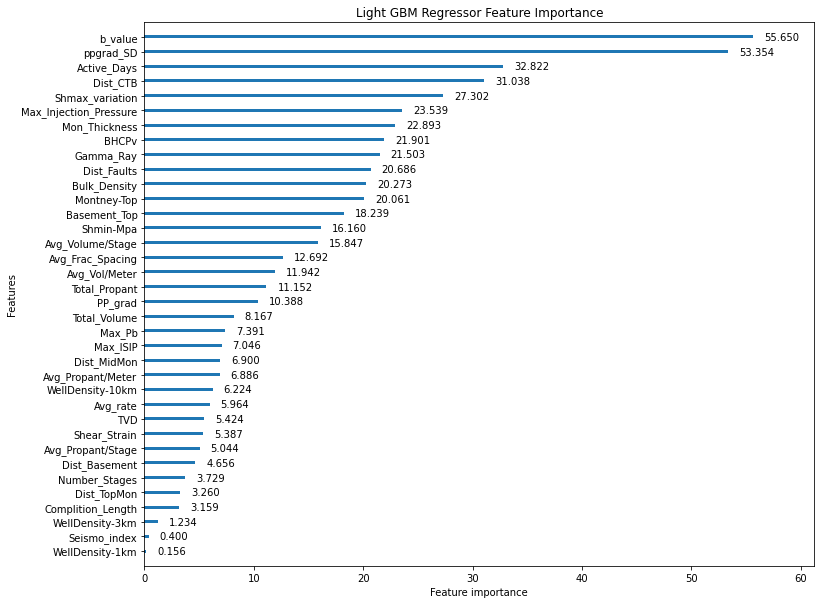

In [17]:
modellgb= lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 100,n_estimators=163,num_leaves= 71).fit(X_train_scaled, y_train)
lgb.plot_importance(modellgb, importance_type='gain', grid=False)
fig = plt.gcf()
plt.title("Light GBM Regressor Feature Importance")
fig.set_figheight(10)
fig.set_figwidth(12)
plt.savefig('LGBM_R_FI_200dpi.png', dpi=200)

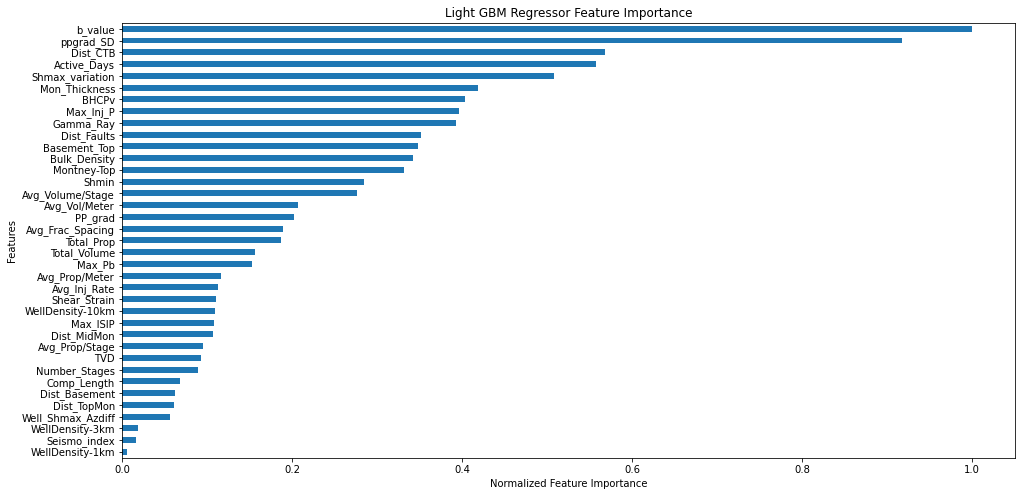

In [7]:
modellgb= lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 100,n_estimators=163,num_leaves= 71,importance_type='gain')
modellgb.fit(X_train_scaled, y_train)
feat_importances = pd.Series(modellgb.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Light GBM Regressor Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('LGBM_R_FI_GOPnorm_200dpi.png', dpi=200)




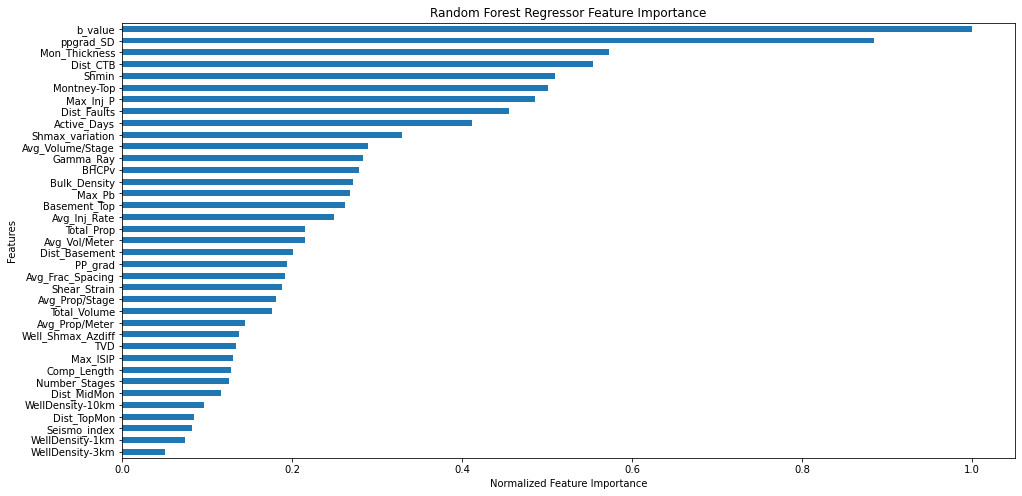

In [8]:
feature_names = [f'feature {i}' for i in range(X_train_scaled.shape[1])]
modelrf= RandomForestRegressor(max_depth= 67)
modelrf.fit(X_train_scaled, y_train)
feat_importances = pd.Series(modelrf.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Random Forest Regressor Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('RF_R_FInorm_200dpi.png', dpi=200)



In [7]:
modellgb= lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 100,n_estimators=163,num_leaves= 71).fit(X_train_scaled, y_train)
explainer = shap.TreeExplainer(modellgb,X_train_scaled)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values, max_display=25,show=False)
fig = plt.gcf()
plt.title("Feature Importance of Geological & Operational Features \n"
    "for Severity of Iinduced Seismicity events, with Light_GBM Regressor")
fig.set_figheight(12)
fig.set_figwidth(24)
plt.savefig('LGBM_R_SHAP_summary_200dpi.png', dpi=200)

TypeError: 'TreeExplainer' object is not callable

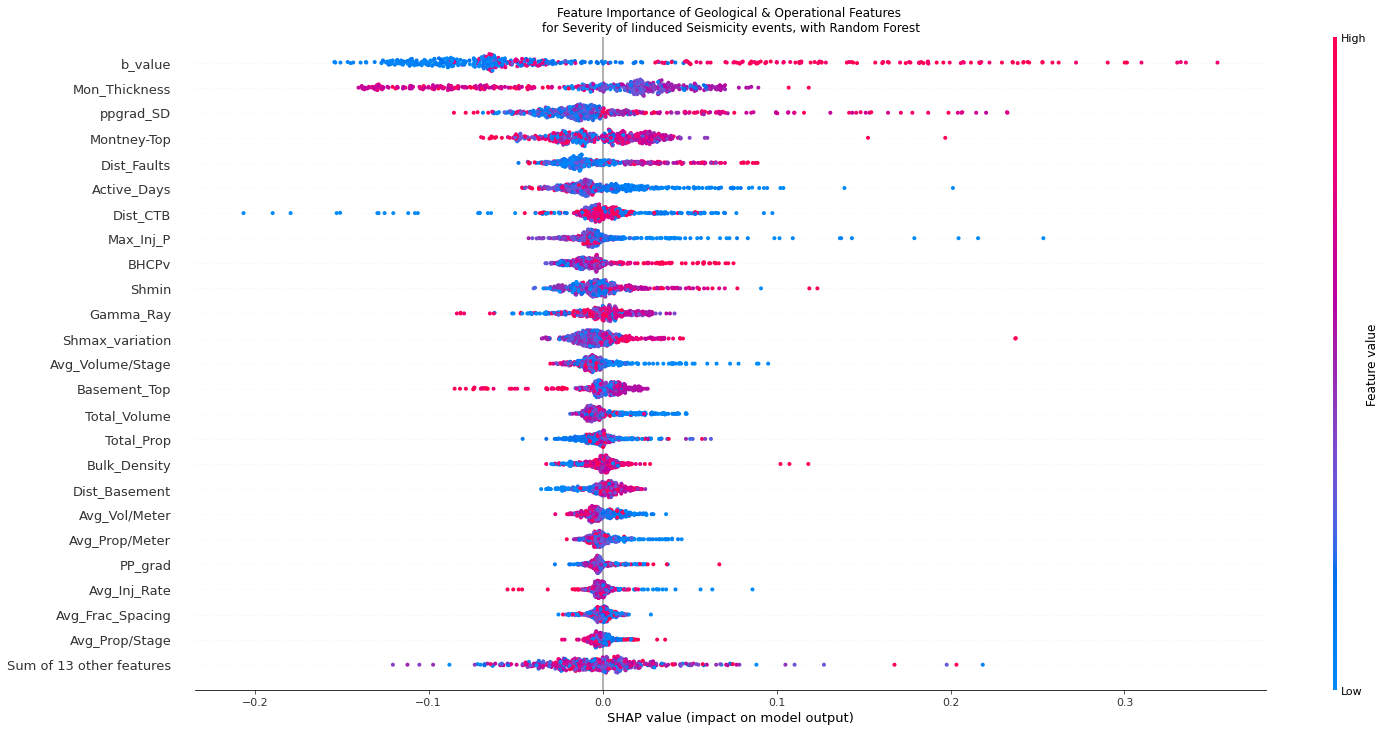

In [10]:
modelrf= RandomForestRegressor(max_depth= 67).fit(X_train_scaled, y_train)
explainer = shap.TreeExplainer(modelrf,X_train_scaled, check_additivity=False)
shap_values = explainer(X_train_scaled, check_additivity=False)
shap.plots.beeswarm(shap_values, max_display=25,show=False)
fig = plt.gcf()
plt.title("Feature Importance of Geological & Operational Features \n"
    "for Severity of Iinduced Seismicity events, with Random Forest")
fig.set_figheight(12)
fig.set_figwidth(24)
plt.savefig('RF_R_SHAP_summary_200dpi.png', dpi=200)

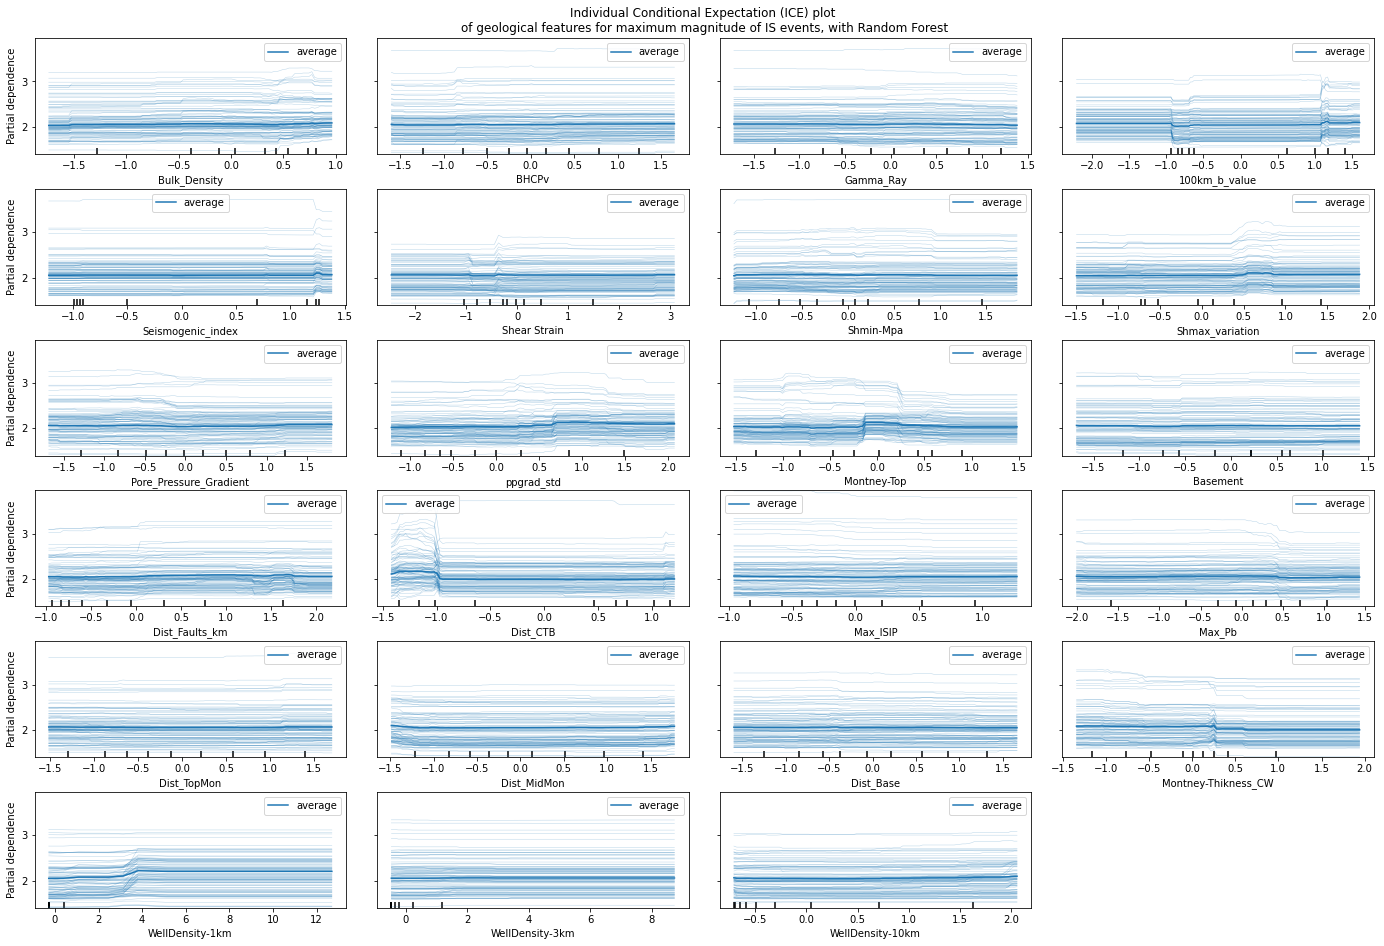

In [9]:
fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Individual Conditional Expectation (ICE) plot \n"
    "of geological features for maximum magnitude of IS events, with Random Forest")
display = plot_partial_dependence(modelrf, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','100km_b_value','Seismogenic_index','Shear Strain','Shmin-Mpa','Shmax_variation','Pore_Pressure_Gradient','ppgrad_std','Montney-Top','Basement','Dist_Faults_km','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4, kind="both", subsample=100)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('ICE_plot_RF_R_100dpi', dpi=100)

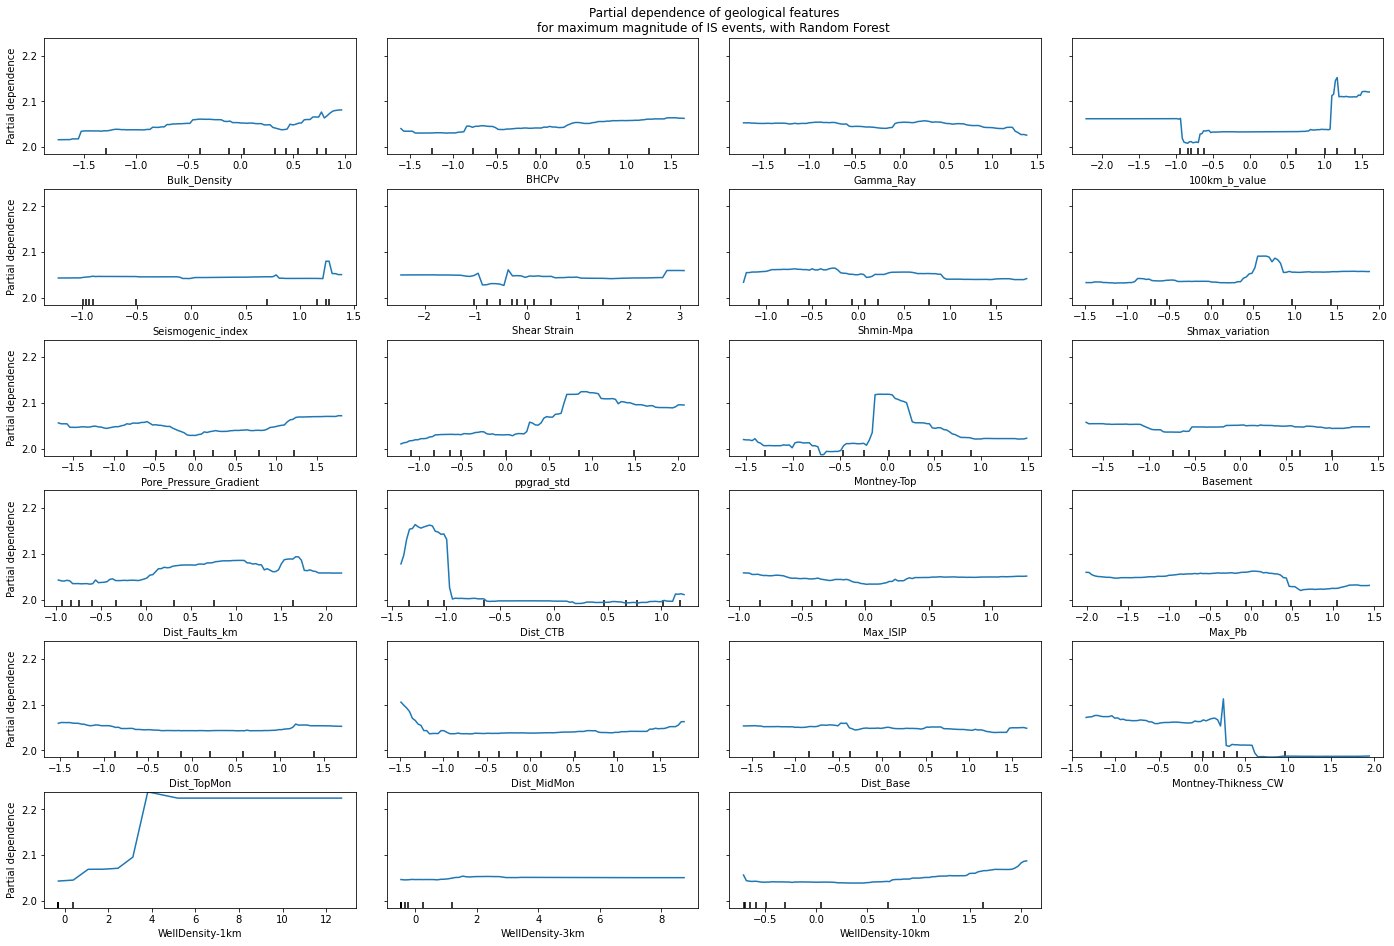

In [10]:
fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Partial dependence of geological features\n"
    "for maximum magnitude of IS events, with Random Forest")
display = plot_partial_dependence(modelrf, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','100km_b_value','Seismogenic_index','Shear Strain','Shmin-Mpa','Shmax_variation','Pore_Pressure_Gradient','ppgrad_std','Montney-Top','Basement','Dist_Faults_km','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('PDP_RF_R_100dpi', dpi=100)

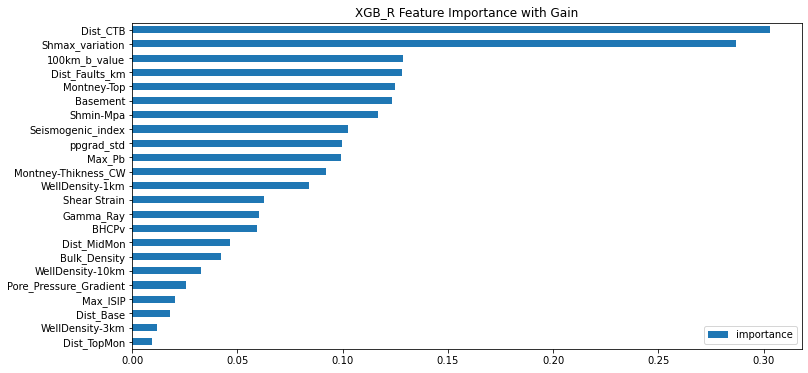

In [30]:
modelxgb= xgb.XGBRegressor(eta= 0.9,gamma= 8.781492770662131e-06 , max_depth=100,verbosity = 0).fit(X_train_scaled, y_train)
feature_important = modelxgb.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["importance"]).sort_values(by = "importance", ascending=True)
data.plot(kind='barh')
fig = plt.gcf()
plt.title("XGB_R Feature Importance with Gain")
fig.set_figheight(6)
fig.set_figwidth(12)
plt.savefig('XGB_R_FIgain_200dpi.png', dpi=200)

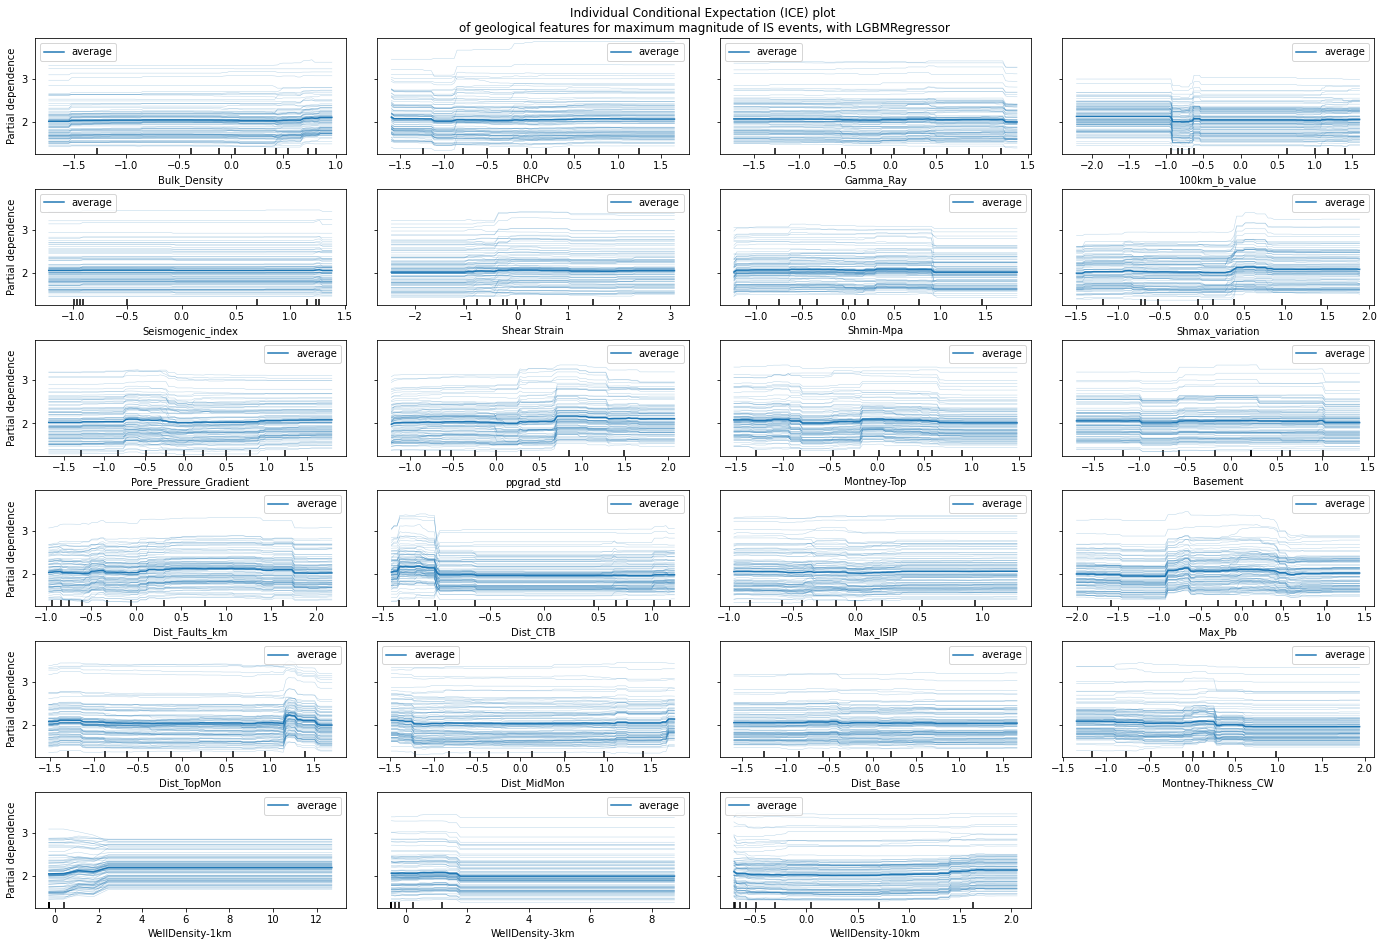

In [65]:

fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Individual Conditional Expectation (ICE) plot \n"
    "of geological features for maximum magnitude of IS events, with LGBMRegressor")
display = plot_partial_dependence(model, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','100km_b_value','Seismogenic_index','Shear Strain','Shmin-Mpa','Shmax_variation','Pore_Pressure_Gradient','ppgrad_std','Montney-Top','Basement','Dist_Faults_km','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4, kind="both", subsample=100)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('ICE_plot_lgbm_100dpi', dpi=100)

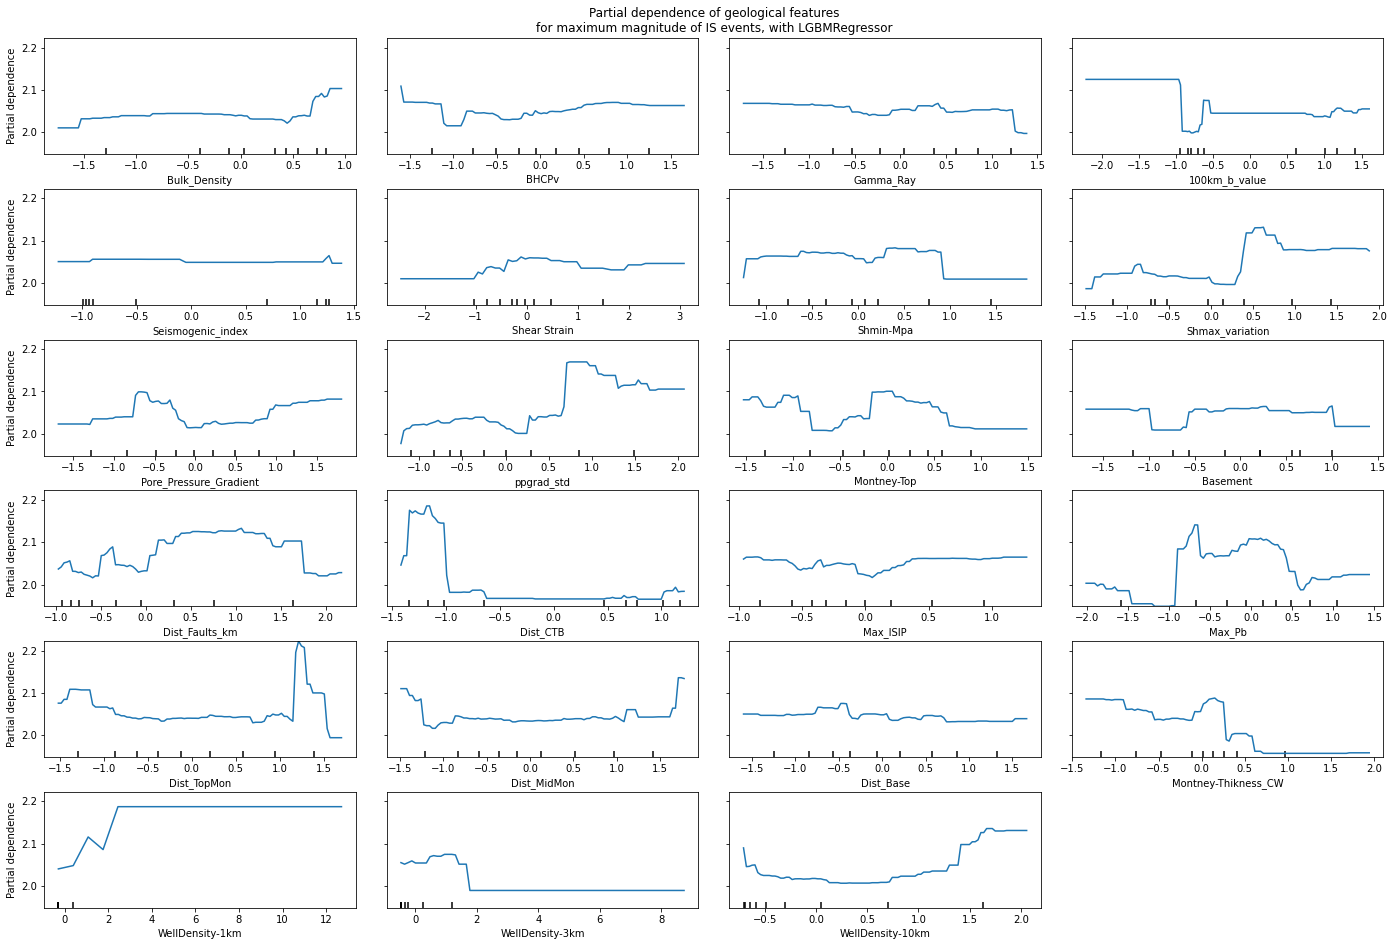

In [64]:

fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Partial dependence of geological features\n"
    "for maximum magnitude of IS events, with LGBMRegressor")
display = plot_partial_dependence(model, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','100km_b_value','Seismogenic_index','Shear Strain','Shmin-Mpa','Shmax_variation','Pore_Pressure_Gradient','ppgrad_std','Montney-Top','Basement','Dist_Faults_km','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('PDP_lgbm_100dpi', dpi=100)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


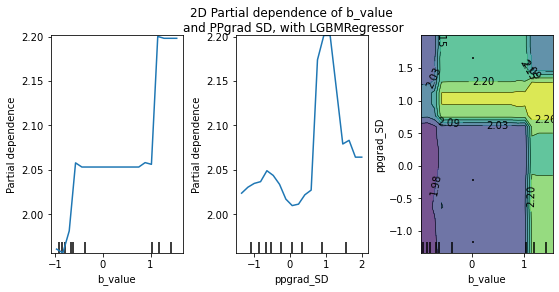

In [23]:
modellgb= lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 100,n_estimators=163,num_leaves= 71).fit(X_train_scaled, y_train)
features = ['b_value', 'ppgrad_SD', ('b_value', 'ppgrad_SD')]
#print('Computing partial dependence plots...')
#tic = time()
fig, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = plot_partial_dependence(
    modellgb, X_train_scaled, features, kind='average', n_jobs=3, grid_resolution=20,
    ax=ax,
)
#print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    '2D Partial dependence of b_value \n'
    'and PPgrad SD, with LGBMRegressor'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('2D_pdp_b_value-PPgSD_300dpi', dpi=300)

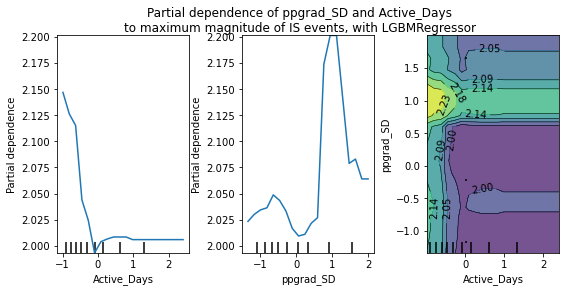

In [25]:
modellgb= lgb.LGBMRegressor(learning_rate= 0.08147092740218508,max_depth= 100,n_estimators=163,num_leaves= 71).fit(X_train_scaled, y_train)
features = ['Active_Days','ppgrad_SD', ('Active_Days','ppgrad_SD')]
#print('Computing partial dependence plots...')
#tic = time()
fig, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = plot_partial_dependence(
    modellgb, X_train_scaled, features, kind='average', n_jobs=3, grid_resolution=20,
    ax=ax,
)
#print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of ppgrad_SD and Active_Days\n'
    'to maximum magnitude of IS events, with LGBMRegressor'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('2D_pdp_Active_Days-ppgrad_SD_300dpi', dpi=300)